<a href="https://colab.research.google.com/github/Arvind-0314/Formula-1-Win-Predictor/blob/main/F1__Win_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Fetch F1 data for a given year from the Ergast API
def fetch_f1_data(year):
    url = f"http://ergast.com/api/f1/{year}/results.json?limit=1000"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        races = data['MRData']['RaceTable']['Races']
        records = []

        for race in races:
            for result in race['Results']:
                records.append({
                    'Race_Name': race['raceName'],
                    'Circuit': race['Circuit']['circuitName'],
                    'Date': race['date'],
                    'Driver': result['Driver']['familyName'],
                    'Constructor': result['Constructor']['name'],
                    'Race_Position': int(result['position']),
                    'Laps': int(result['laps']),
                    'Status': result['status']
                })

        return pd.DataFrame(records)
    else:
        print("Failed to fetch data")
        return pd.DataFrame()

df = fetch_f1_data(2024)
print(df.head())

In [ ]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Race_Name', 'Circuit', 'Date', 'Driver', 'Constructor',
       'Race_Position', 'Laps', 'Status'],
      dtype='object')


In [ ]:
#preprocess data
def preprocess_data(df):
    if 'Constructor' not in df.columns:
        raise KeyError("The 'Constructor' column is missing from the dataset.")

    df['Race_Winner'] = df['Race_Position'].apply(lambda x: 1 if x == 1 else 0)

    df['Driver'] = df['Driver'].astype('category').cat.codes
    df['Circuit'] = df['Circuit'].astype('category').cat.codes
    return df

df = preprocess_data(df)
print(df.head())


In [ ]:
X = df[['Driver', 'Circuit']]
y = df['Race_Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Classifier
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ", cm)

Accuracy: 90.00%
Confusion Matrix:  [[18  1]
 [ 1  0]]


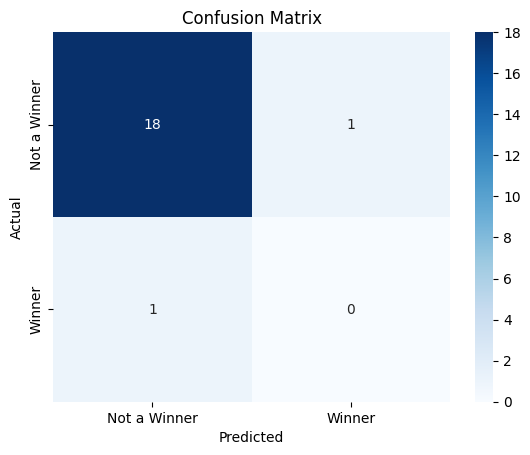

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not a Winner', 'Winner'], yticklabels=['Not a Winner', 'Winner'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

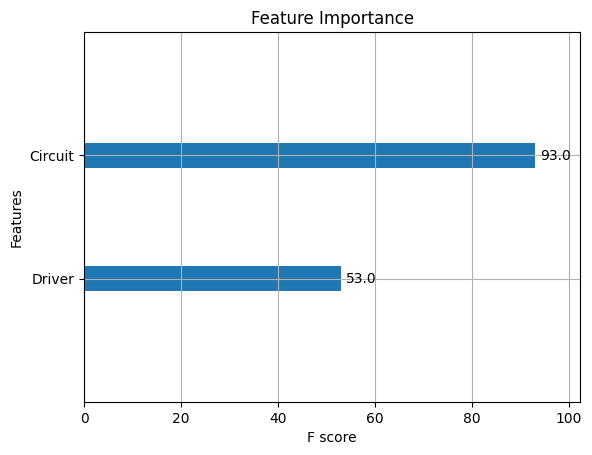

In [ ]:
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()